In [ ]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import load_img, ImageDataGenerator
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten
from matplotlib import pyplot as plt

In [ ]:
!pip install -q kaggle

In [ ]:
from google.colab import files
files.upload()

TypeError: 'NoneType' object is not subscriptable

In [ ]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d msambare/fer2013

Dataset URL: https://www.kaggle.com/datasets/msambare/fer2013
License(s): DbCL-1.0


In [ ]:
!unzip -q fer2013.zip -d fer2013_images

In [ ]:
import os

print("Train folder:")
dirs = os.listdir('/content/fer2013_images/train')
for dir in dirs:
    path = os.path.join('/content/fer2013_images/train', dir)  # Create the full path
    if os.path.isdir(path):  # Check if it is a directory
        files = os.listdir(path)  # List files in the directory
        print(dir + ' folder has ' + str(len(files)) + ' Images')

Train folder:
surprise folder has 3171 Images
angry folder has 3995 Images
happy folder has 7215 Images
fear folder has 4097 Images
neutral folder has 4965 Images
disgust folder has 436 Images
sad folder has 4830 Images


In [ ]:
print("Test folder:")
dirs2 = os.listdir('/content/fer2013_images/test')
for dir in dirs2:
    path = os.path.join('/content/fer2013_images/test', dir)  # Create the full path
    if os.path.isdir(path):  # Check if it is a directory
        files = os.listdir(path)  # List files in the directory
        print(dir + ' folder has ' + str(len(files)) + ' Images')

Test folder:
surprise folder has 831 Images
angry folder has 958 Images
happy folder has 1774 Images
fear folder has 1024 Images
neutral folder has 1233 Images
disgust folder has 111 Images
sad folder has 1247 Images


In [ ]:
img_size = 48

In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    '/content/fer2013_images/train',
    seed=123,
    validation_split=0.2,
    batch_size=32,
    subset='training',
    image_size=(img_size, img_size),
    color_mode='grayscale'
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    '/content/fer2013_images/train',
    seed=123,
    validation_split=0.2,
    batch_size=64,
    subset='validation',
    image_size=(img_size, img_size),
    color_mode='grayscale'
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    '/content/fer2013_images/test',
    seed=123,
    batch_size=64,
    image_size=(img_size, img_size),
    color_mode='grayscale'
)

Found 28709 files belonging to 7 classes.
Using 22968 files for training.
Found 28709 files belonging to 7 classes.
Using 5741 files for validation.
Found 7178 files belonging to 7 classes.


In [ ]:
class_names = train_ds.class_names
print(class_names)

['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


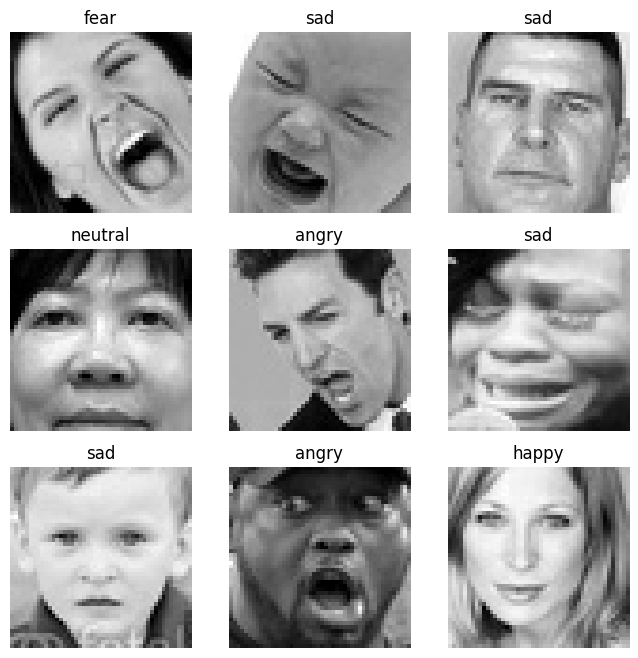

In [ ]:
plt.figure(figsize=(8, 8))
for images, labels in train_ds.take(1):
    for i in range(9):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype('uint8'), cmap='gray')  # Grayscale cmap
        plt.title(class_names[labels[i]])
        plt.axis('off')
plt.show()

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
#Caches the dataset in memory and speeds up training

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = AUTOTUNE)
#CACHE: prevents overfitting and ensures the model generalizes better by showing the data in a random order during training
#PREFETCH: overlaps data preprocessing with model training. Reduce idle time.

test_ds = test_ds.cache().prefetch(buffer_size = AUTOTUNE)

Data Augmentation

In [ ]:
from tensorflow.keras.layers import Input

In [ ]:
data_augmentation = Sequential([
    layers.Input(shape=(img_size, img_size, 1)),
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
])

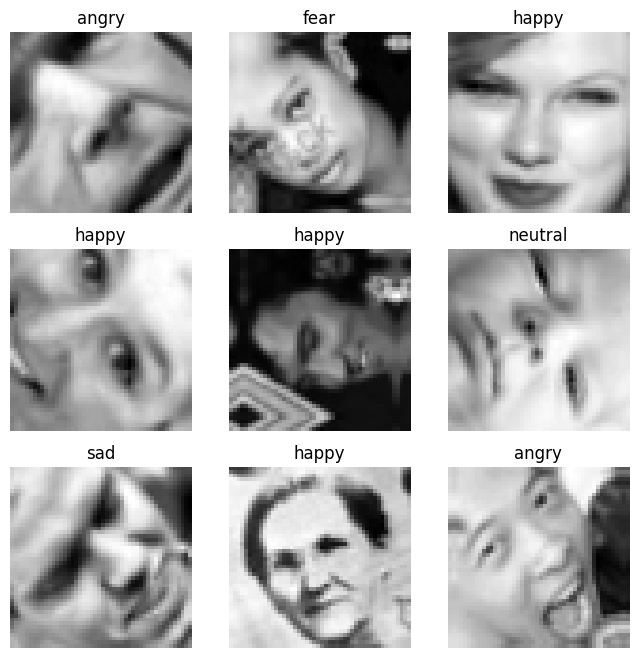

In [ ]:
plt.figure(figsize=(8, 8))
for images, labels in train_ds.take(1):
    augmented_images = data_augmentation(images)  # Apply augmentation
    for i in range(9):
        plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[i].numpy().astype('uint8'), cmap='gray')
        plt.title(class_names[labels[i]])
        plt.axis('off')
plt.show()

Model Creation

In [ ]:
normalization_layer = layers.Rescaling(1./255)


cnn_model = Sequential([
    data_augmentation,
    normalization_layer,

    layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(48, 48, 1)),
    layers.BatchNormalization(),

    # Second block: 64 filters
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Dropout(0.25),

    # Fourth block: 128 filters
    layers.Conv2D(128, kernel_size=(3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Dropout(0.25),

    # Fifth block: 256 filters
    layers.Conv2D(256, kernel_size=(3, 3), activation='relu'),
    layers.BatchNormalization(),

    # Dense layers
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(7, activation='softmax')
])

In [ ]:
cnn_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Define callbacks for better training
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

In [ ]:
cnn_history = cnn_model.fit(
    train_ds,
    epochs=50,
    validation_data=val_ds,
    callbacks=[early_stopping]
)

Epoch 1/50
718/718 ━━━━━━━━━━━━━━━━━━━━ 21s 23ms/step - accuracy: 0.2046 - loss: 2.4212 - val_accuracy: 0.3094 - val_loss: 1.7212
Epoch 2/50
718/718 ━━━━━━━━━━━━━━━━━━━━ 16s 23ms/step - accuracy: 0.3001 - loss: 1.7714 - val_accuracy: 0.3047 - val_loss: 1.8348
Epoch 3/50
718/718 ━━━━━━━━━━━━━━━━━━━━ 16s 22ms/step - accuracy: 0.3838 - loss: 1.5805 - val_accuracy: 0.4440 - val_loss: 1.4418
Epoch 4/50
718/718 ━━━━━━━━━━━━━━━━━━━━ 16s 22ms/step - accuracy: 0.4332 - loss: 1.4680 - val_accuracy: 0.4325 - val_loss: 1.4859
Epoch 5/50
718/718 ━━━━━━━━━━━━━━━━━━━━ 16s 23ms/step - accuracy: 0.4533 - loss: 1.4197 - val_accuracy: 0.5074 - val_loss: 1.3023
Epoch 6/50
718/718 ━━━━━━━━━━━━━━━━━━━━ 16s 22ms/step - accuracy: 0.4677 - loss: 1.3776 - val_accuracy: 0.4835 - val_loss: 1.3593
Epoch 7/50
718/718 ━━━━━━━━━━━━━━━━━━━━ 16s 22ms/step - accuracy: 0.4797 - loss: 1.3556 - val_accuracy: 0.5264 - val_loss: 1.2517
Epoch 8/50
718/718 ━━━━━━━━━━━━━━━━━━━━ 16s 23ms/step - accuracy: 0.4926 - loss: 1.3262 - 

In [ ]:
def convert_to_rgb(image, label):
    image = tf.image.grayscale_to_rgb(image)
    return image, label

train_ds_rgb = train_ds.map(convert_to_rgb, num_parallel_calls=AUTOTUNE)
val_ds_rgb = val_ds.map(convert_to_rgb, num_parallel_calls=AUTOTUNE)
test_ds_rgb = test_ds.map(convert_to_rgb, num_parallel_calls=AUTOTUNE)

In [ ]:
from tensorflow.keras.applications import ResNet50

# Load ResNet50 base
convolutional_base = ResNet50(weights='imagenet', include_top=False, input_shape=(192, 192, 3))

# Define model
resnet_model = Sequential()
resnet_model.add(layers.Input(shape=(48, 48, 3)))
resnet_model.add(layers.UpSampling2D((2, 2)))  # 48 → 96
resnet_model.add(layers.UpSampling2D((2, 2)))  # 96 → 192
resnet_model.add(convolutional_base)
resnet_model.add(layers.Flatten())
resnet_model.add(layers.BatchNormalization())
resnet_model.add(layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)))
resnet_model.add(layers.Dropout(0.3))
resnet_model.add(layers.BatchNormalization())
resnet_model.add(layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)))
resnet_model.add(layers.Dropout(0.3))
resnet_model.add(layers.BatchNormalization())
resnet_model.add(layers.Dense(7, activation='softmax'))

In [ ]:
resnet_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Define callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

In [ ]:
resnet_history = resnet_model.fit(
    train_ds_rgb,
    epochs=30,
    validation_data=val_ds_rgb,
    callbacks=[early_stopping]
)

Epoch 1/30
718/718 ━━━━━━━━━━━━━━━━━━━━ 270s 282ms/step - accuracy: 0.3407 - loss: 5.2310 - val_accuracy: 0.5459 - val_loss: 4.0552
Epoch 2/30
718/718 ━━━━━━━━━━━━━━━━━━━━ 163s 227ms/step - accuracy: 0.5661 - loss: 3.8236 - val_accuracy: 0.5788 - val_loss: 3.1704
Epoch 3/30
718/718 ━━━━━━━━━━━━━━━━━━━━ 202s 227ms/step - accuracy: 0.6481 - loss: 2.8128 - val_accuracy: 0.5962 - val_loss: 2.5419
Epoch 4/30
718/718 ━━━━━━━━━━━━━━━━━━━━ 201s 226ms/step - accuracy: 0.7251 - loss: 2.0761 - val_accuracy: 0.6034 - val_loss: 2.2008
Epoch 5/30
718/718 ━━━━━━━━━━━━━━━━━━━━ 201s 225ms/step - accuracy: 0.7928 - loss: 1.5987 - val_accuracy: 0.5813 - val_loss: 2.0858
Epoch 6/30
718/718 ━━━━━━━━━━━━━━━━━━━━ 202s 225ms/step - accuracy: 0.8377 - loss: 1.3202 - val_accuracy: 0.5572 - val_loss: 2.0814
Epoch 7/30
718/718 ━━━━━━━━━━━━━━━━━━━━ 201s 225ms/step - accuracy: 0.8730 - loss: 1.1072 - val_accuracy: 0.5550 - val_loss: 2.1153
Epoch 8/30
718/718 ━━━━━━━━━━━━━━━━━━━━ 202s 225ms/step - accuracy: 0.9024 -

In [ ]:
cnn_loss, cnn_acc = cnn_model.evaluate(test_ds)
print(f"Simple CNN Test Accuracy: {cnn_acc:.4f}")

113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.5807 - loss: 1.1183
Simple CNN Test Accuracy: 0.5889


In [ ]:
cnn_model.save('cnn_model.h5')

In [ ]:
resnet_loss, resnet_acc = resnet_model.evaluate(test_ds_rgb)
print(f"ResNet50 Test Accuracy: {resnet_acc:.4f}")

113/113 ━━━━━━━━━━━━━━━━━━━━ 16s 138ms/step - accuracy: 0.6020 - loss: 1.8936
ResNet50 Test Accuracy: 0.6120


In [ ]:
resnet_model.save('resnet_model.h5')